## LIBRERIAS

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

## CARGAMOS LA BASE DE DATOS

In [ ]:
# Crear la carpeta .kaggle si no existe
os.makedirs("/root/.kaggle", exist_ok=True)
# Mover el archivo kaggle.json a la carpeta
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
# Dar permisos adecuados
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d deathperminut/material-spinners-data

Dataset URL: https://www.kaggle.com/datasets/deathperminut/material-spinners-data
License(s): CC0-1.0
 99% 125M/126M [00:06<00:00, 23.4MB/s]
100% 126M/126M [00:06<00:00, 19.5MB/s]


In [ ]:
# Nombre del archivo descargado (ajústalo según sea necesario)
dataset_zip = "/content/material-spinners-data.zip"
# Extraer los archivos
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")
# Ver archivos extraídos
os.listdir("dataset")

['__notebook__.ipynb', 'data.npy.npz']

In [ ]:
#load data
file_ = '/content/dataset/data.npy.npz'
data = np.load(file_)
T,Jex2 =data['T'],data['Jex2']

In [ ]:
# Cargar nuevamente

loaded = np.load("/content/drive/MyDrive/imagenes_comprimidas.npz")
MS = loaded["data"].astype('float16')
Y_ = Jex2.reshape(-1, 1)

In [ ]:
del loaded
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS, Jex2.reshape(-1, 1), test_size=0.2, random_state=42)
del MS, Jex2
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

## JEX 2

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(1, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 211s 161ms/step - loss: 0.0465 - mae: 0.1337 - val_loss: 0.0656 - val_mae: 0.2112
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - loss: 0.0071 - mae: 0.0644 - val_loss: 0.0342 - val_mae: 0.1556
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0059 - mae: 0.0580 - val_loss: 0.0338 - val_mae: 0.1443
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0055 - mae: 0.0566 - val_loss: 0.0801 - val_mae: 0.2388
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0051 - mae: 0.0544 - val_loss: 0.0620 - val_mae: 0.2105
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0048 - mae: 0.0523 - val_loss: 1398.9977 - val_mae: 27.8202
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - loss: 0.0043 - mae: 0.0498 - val_loss: 0.5239 - val_mae: 0.5266
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0041 - mae: 0.0488 - val_loss: 0.1621 - val_mae: 0.3432
Epoch 9/15
676/676 ━━━━━━━━━━━━━━━

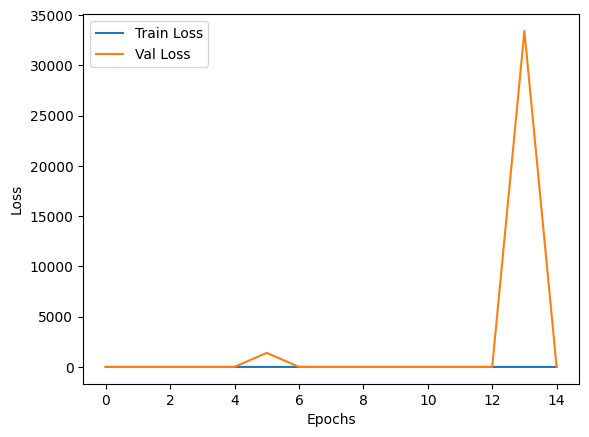

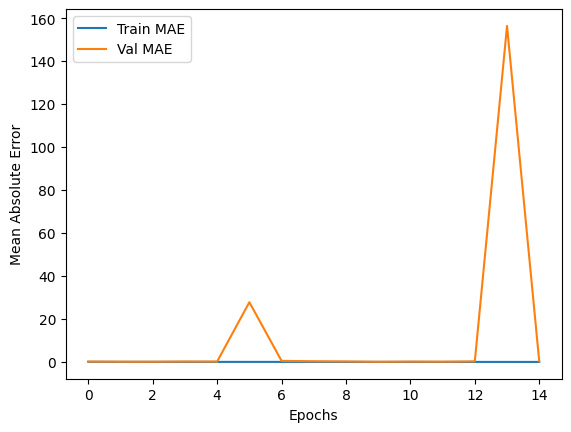

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━

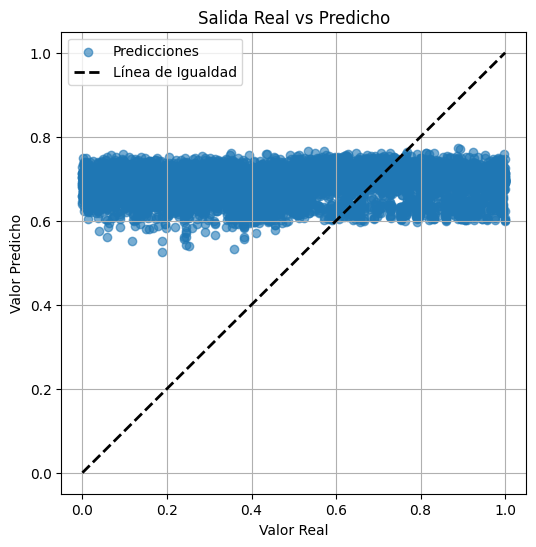

In [ ]:
# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)
y_real = np.concatenate(y_real_list, axis=0)

# Graficar predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_real[:, 0], y_pred[:, 0], alpha=0.6, label="Predicciones")
plt.plot([min(y_real[:, 0]), max(y_real[:, 0])],
         [min(y_real[:, 0]), max(y_real[:, 0])], 'k--', lw=2, label="Línea de Igualdad")  # Línea de referencia
plt.title('Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_efficient_regresionjex2.h5')  # Guarda en formato HDF5

In [ ]:
import torch
torch.cuda.empty_cache()  # Si usas PyTorch

In [ ]:
import gc
import sys

del train_dataset, val_dataset
# Forzar recolección de basura
gc.collect()

150

## T

In [ ]:
# Cargar nuevamente

loaded = np.load("/content/drive/MyDrive/imagenes_comprimidas.npz")
MS = loaded["data"].astype('float16')

In [ ]:
del loaded
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS, T.reshape(-1, 1), test_size=0.2, random_state=42)
del MS
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(1, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 210s 162ms/step - loss: 0.0443 - mae: 0.1404 - val_loss: 0.0949 - val_mae: 0.2460
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - loss: 0.0151 - mae: 0.0868 - val_loss: 0.0960 - val_mae: 0.2352
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - loss: 0.0132 - mae: 0.0807 - val_loss: 0.0630 - val_mae: 0.1722
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - loss: 0.0123 - mae: 0.0775 - val_loss: 0.0855 - val_mae: 0.2152
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - loss: 0.0108 - mae: 0.0731 - val_loss: 0.0485 - val_mae: 0.1663
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - loss: 0.0096 - mae: 0.0695 - val_loss: 0.0448 - val_mae: 0.1762
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - loss: 0.0088 - mae: 0.0665 - val_loss: 0.0455 - val_mae: 0.1494
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - loss: 0.0080 - mae: 0.0640 - val_loss: 0.0616 - val_mae: 0.1698
Epoch 9/15
676/676 ━━━━━━━━━━━━━━━━━━━

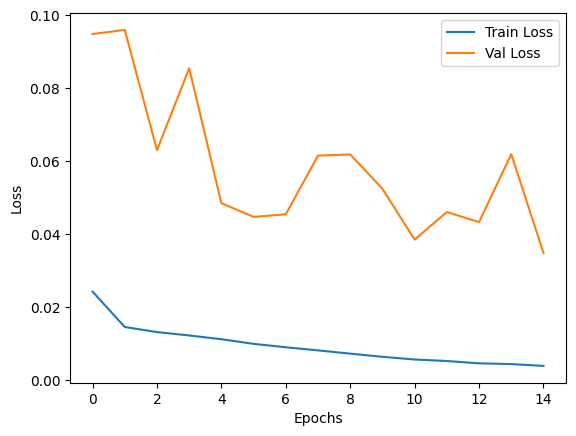

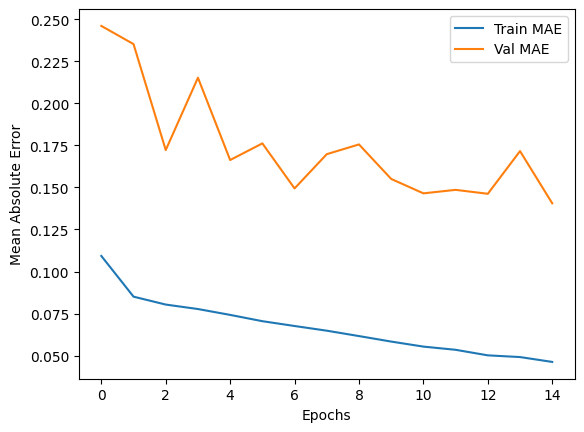

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━

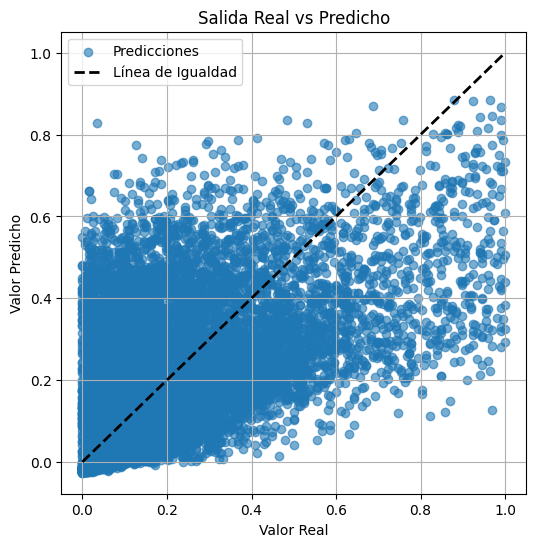

In [ ]:
# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)
y_real = np.concatenate(y_real_list, axis=0)

# Graficar predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_real[:, 0], y_pred[:, 0], alpha=0.6, label="Predicciones")
plt.plot([min(y_real[:, 0]), max(y_real[:, 0])],
         [min(y_real[:, 0]), max(y_real[:, 0])], 'k--', lw=2, label="Línea de Igualdad")  # Línea de referencia
plt.title('Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_efficientNet_regresionT.h5')  # Guarda en formato HDF5

## MULTIVARIADO

In [ ]:
# Cargar nuevamente
loaded = np.load("/content/drive/MyDrive/imagenes_comprimidas.npz")
MS = loaded["data"].astype('float16')

In [ ]:
del loaded
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS,np.hstack((np.expand_dims(T, axis=-1),np.expand_dims(Jex2, axis=-1))), test_size=0.2, random_state=42)
del MS
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(2, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 217s 166ms/step - loss: 0.0347 - mae: 0.1270 - val_loss: 0.0668 - val_mae: 0.1982
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0105 - mae: 0.0733 - val_loss: 0.0765 - val_mae: 0.2175
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0093 - mae: 0.0689 - val_loss: 0.0738 - val_mae: 0.2094
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0086 - mae: 0.0654 - val_loss: 0.1561 - val_mae: 0.2752
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0078 - mae: 0.0629 - val_loss: 0.0683 - val_mae: 0.1998
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0073 - mae: 0.0613 - val_loss: 0.0626 - val_mae: 0.1894
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0070 - mae: 0.0604 - val_loss: 0.0835 - val_mae: 0.2193
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0061 - mae: 0.0566 - val_loss: 0.0618 - val_mae: 0.1952
Epoch 9/15
676/676 ━━━━━━━━━━━━━━━━━━━

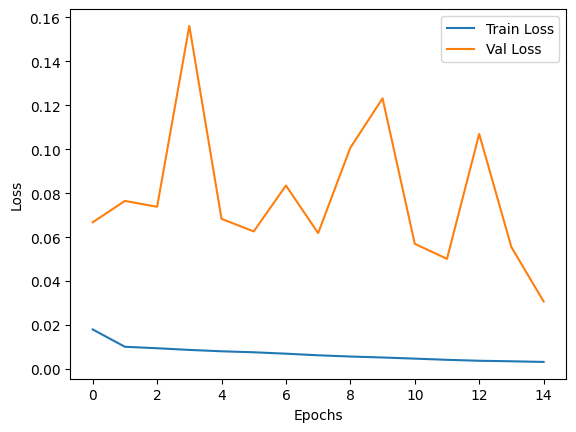

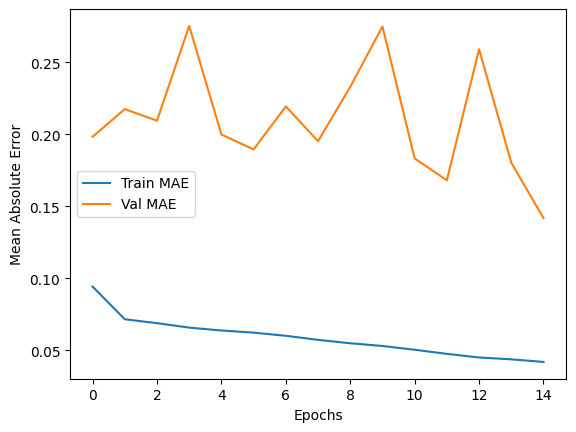

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━

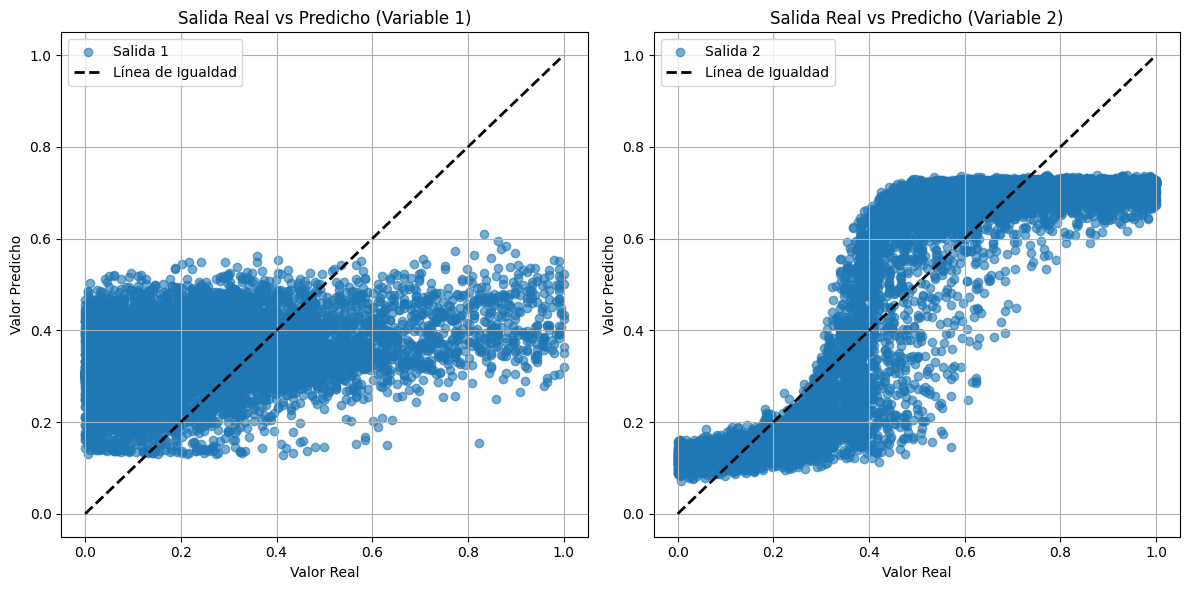

In [ ]:

# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo (ahora con 2 salidas)
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)  # (N, 2)
y_real = np.concatenate(y_real_list, axis=0)  # (N, 2)

# Graficar cada salida por separado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 2 gráficos lado a lado

for i in range(2):  # Para ambas salidas
    axes[i].scatter(y_real[:, i], y_pred[:, i], alpha=0.6, label=f'Salida {i+1}')
    axes[i].plot([min(y_real[:, i]), max(y_real[:, i])],
                 [min(y_real[:, i]), max(y_real[:, i])], 'k--', lw=2, label="Línea de Igualdad")
    axes[i].set_title(f'Salida Real vs Predicho (Variable {i+1})')
    axes[i].set_xlabel('Valor Real')
    axes[i].set_ylabel('Valor Predicho')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_EfficienNet_regresionTJex2.h5')  # Guarda en formato HDF5